# Project: NLP-based Text Similarity Detection

## Project Overview
This project aims to develop an NLP-based text similarity system that can automatically identify duplicate or highly similar documents 
## Methodology
1. **Data Collection**: Load dataset from Hugging Face.
2. **Preprocessing**: Tokenization, stopword removal, lemmatization.
3. **Feature Extraction**: TF-IDF vectorization and Cosine Similarity computation.
4. **Model Training**: Logistic Regression based on similarity scores.
5. **Evaluation**: Accuracy, Precision, Recall, F1-score, and Confusion Matrix.

In [43]:
!pip install pandas numpy scikit-learn nltk datasets matplotlib seaborn hf_xet huggingface_hub[hf_xet]

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import string
import joblib

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\addis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\addis\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\addis\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\addis\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\addis\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

## 2. Load Dataset
We will use the [`sentence-transformers/quora-duplicates`](https://huggingface.co/datasets/sentence-transformers/quora-duplicates) dataset (pair-class subset).

In [44]:
try:
    dataset = load_dataset("sentence-transformers/quora-duplicates", "pair-class")
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading dataset: {e}")
df = pd.DataFrame(dataset['train'])

# Rename columns to match existing code
df = df.rename(columns={'sentence1': 'text1', 'sentence2': 'text2'})

# Using 10,000 samples to avoid memory error
df = df.sample(n=10000, random_state=42)
print(f"Dataset sampled to {len(df)} rows.")


print(df.head())
print(df.columns)

Dataset loaded successfully.
Dataset sampled to 10000 rows.
                                                    text1  \
8067                   How do I play Pokémon GO in Korea?   
368101  What are some of the best side dishes for crab...   
70497   Which is more advisable and better material fo...   
226567       How do I improve logical programming skills?   
73186              How close we are to see 3rd world war?   

                                                    text2  label  
8067                   How do I play Pokémon GO in China?      0  
368101  What are some good side dishes for buffalo chi...      0  
70497       What is the best server setup for buddypress?      0  
226567  How can I improve my logical skills for progra...      1  
73186                       How close is a World War III?      1  
Index(['text1', 'text2', 'label'], dtype='object')


## 3. Data Preprocessing
Cleaning the text data by tokenizing, removing stopwords, and lemmatizing.

In [45]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return " ".join(cleaned_tokens)


df['processed_1'] = df['text1'].apply(preprocess_text)
df['processed_2'] = df['text2'].apply(preprocess_text)

print(df[['processed_1', 'processed_2']].head())

                                              processed_1  \
8067                                play pokémon go korea   
368101                           best side dish crab cake   
70497   advisable better material crash test automobil...   
226567                  improve logical programming skill   
73186                             close see 3rd world war   

                              processed_2  
8067                play pokémon go china  
368101     good side dish buffalo chicken  
70497        best server setup buddypress  
226567  improve logical skill programming  
73186                 close world war iii  


## 4. Feature Extraction
We will compute the TF-IDF vectors for the documents and then calculate the Cosine Similarity between pairs.

In [46]:
# Use max_features to limit vocabulary size and avoid MemoryError
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)

# Fit the vectorizer on all text data to ensure consistent vocabulary
all_text = pd.concat([df['processed_1'], df['processed_2']])
print(f"Fitting vectorizer on {len(all_text)} documents...")
tfidf_vectorizer.fit(all_text)

print("Transforming documents...")
tfidf_1 = tfidf_vectorizer.transform(df['processed_1'])
tfidf_2 = tfidf_vectorizer.transform(df['processed_2'])

# Cosine Similarity for each pair
# cosine_similarity returns a matrix, we need the diagonal elements (pair-wise)
# However, computing the full matrix for large datasets is memory intensive.
# We can compute row-wise dot product of normalized vectors.

from sklearn.metrics.pairwise import linear_kernel

cosine_scores = []
print("Computing cosine similarity...")
for i in range(tfidf_1.shape[0]):
    # Compute similarity between doc i in list 1 and doc i in list 2
    # Reshape to (1, -1) to pass to cosine_similarity
    similarity = cosine_similarity(tfidf_1[i], tfidf_2[i])[0][0]
    cosine_scores.append(similarity)

df['cosine_similarity'] = cosine_scores

print(df[['cosine_similarity', 'label']].head())

Fitting vectorizer on 20000 documents...
Transforming documents...
Computing cosine similarity...
        cosine_similarity  label
8067             0.804932      0
368101           0.687396      0
70497            0.000000      0
226567           1.000000      1
73186            0.590278      1


## 5. Model Training and Evaluation
We will use the Cosine Similarity score as a feature to train a Logistic Regression classifier.

Target Label Distribution:
label
0    6265
1    3735
Name: count, dtype: int64
Accuracy: 0.644
Precision: 0.6300578045095542
Recall: 0.644
F1-score: 0.6213517267202197

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.83      0.74      1217
           1       0.57      0.35      0.44       783

    accuracy                           0.64      2000
   macro avg       0.62      0.59      0.59      2000
weighted avg       0.63      0.64      0.62      2000



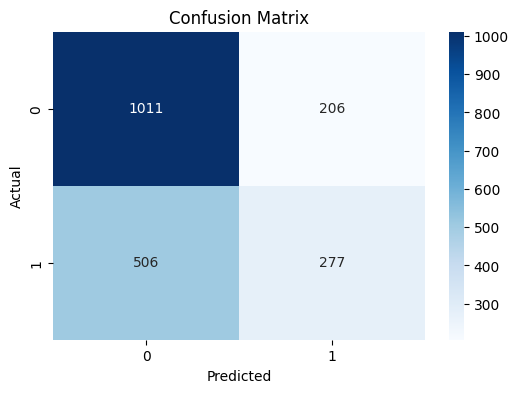

In [47]:
X = df[['cosine_similarity']]
y = df['label']

# Check if labels are continuous/float and convert to binary for classification
# If labels are similarity scores (0.0 to 1.0), we threshold at 0.5
if y.dtype == 'float' or y.dtype == 'float64' or y.dtype == 'float32':
    print("Labels appear to be continuous. Binarizing with threshold 0.5 to convert to classification task...")
    y = (y > 0.5).astype(int)

print("Target Label Distribution:")
print(y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1-score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix Visualization
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Save Model

In [48]:

joblib.dump(log_reg, "models/logistic_model.pkl")
joblib.dump(tfidf_vectorizer, "models/tfidf_vectorizer.pkl")


['models/tfidf_vectorizer.pkl']

## Conclusion
The Logistic Regression model was trained using Cosine Similarity scores derived from TF-IDF vectors of the document pairs. The evaluation metrics above demonstrate the performance of the system.